# Finding a dispersed pulsar

Now we will try to find a new hidden pulsar that has an unkown period and unknown DM. 

* Hint 1: To shift a timeseries, trying using the function np.roll(...) 

* Hint 2: You will obtain 18000 folded profiles this time. Use your SNR calculator to automatically find the pulsar.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n_channels = 8
time = np.linspace(0, 3600, 3600)
data = [np.load(f"../Pulsar_search_tutorial_2/data_2/channel_0{i+1}_telescope_timeseries_DM.npy")[1] for i in range(n_channels)] # index the tuple at [1] to only take the data part, ignoring the time axis

In [4]:
search_periods = np.arange(40, 400, 1) # these are the periods to search
search_DMs = np.arange(0, 500, 10)  # these are the DMs to search
folded_profiles = [] # add a folded profile for each period here

channel_frequencies = [400., 514.28571429, 628.57142857, 742.85714286, 857.14285714, 971.42857143,1085.71428571, 1200.] # MHz, these are the radio frequencies of each channel
K = 1e5 # use this value for the constant 

In [5]:
# this is the same folding code as the first challenge

def stack_profile(period, stacked_channels):
    profile = np.zeros(period)
    n_stacks = int(np.ceil(len(stacked_channels)/period))
    for n in range(n_stacks):
        stack = stacked_channels[n*period: (n+1)*period]
        if len(stack) != period:
            stack = np.pad(stack, (0, period-len(stack)),  mode='constant', constant_values=np.mean(stacked_channels))
        profile += stack
    return profile

In [6]:
# define a function that calculates the time delay for a given DM

def DM2dt(DM, freq):
    return -K * DM * (1/freq**2)

In [7]:
# define a function that inputs the raw channels and applys a time delay to them and then stacks

def dedisperse(DM, freq, data):
    dt = DM2dt(DM, freq) # get time delay

    dm_smeared = []
    for i, psr in enumerate(data): # loop over every channel and apply the correct time delay
        dm_smeared.append(np.roll(psr, int(np.round(dt[i])))) 

    return np.sum(np.array(dm_smeared).astype(np.float32), axis=0) # sum all of the channels together

In [8]:
channel_frequencies = np.array(channel_frequencies) # convert to a numpy array for easy math

folded_profiles = {} # we will store the folded profile in a dictionary
for DM in search_DMs: 
    for period in search_periods: # nested for loop
        stacked_DM_channels = dedisperse(DM, channel_frequencies, data) # shift channels and stack
        profile = stack_profile(period, stacked_DM_channels) # fold stacked channel at period
        folded_profiles[f'P0_{period} DM_{DM}'] = profile # save profile

In [9]:
# same SNR code as before 

def calculate_SNR(profile):
    max_peak = np.max(profile)
    phase = np.linspace(0, 1, len(profile))
    pulse_width = 0.1
    period = len(profile)

    max_peak_location = np.argmax(profile)
    max_peak_phase = max_peak_location/period
    on_pulse_left = max_peak_phase - pulse_width/2
    on_pulse_right = max_peak_phase + pulse_width/2
    mean = np.mean(profile[(phase < on_pulse_left) | (phase > on_pulse_right)])
    standard_deviation = np.std(profile[(phase < on_pulse_left) | (phase > on_pulse_right)])

    SNR = (max_peak - mean) / standard_deviation
    return SNR

In [10]:
# calculate SNR for every folded profile

snr_list = []
for key, profile in folded_profiles.items():
    snr = calculate_SNR(profile)

    snr_list.append(snr)

In [11]:
# find the name of the folded profile with the highest SNR

list(folded_profiles.keys())[np.argmax(snr_list)]

'P0_133 DM_340'

Text(0, 0.5, 'Stacked photon count')

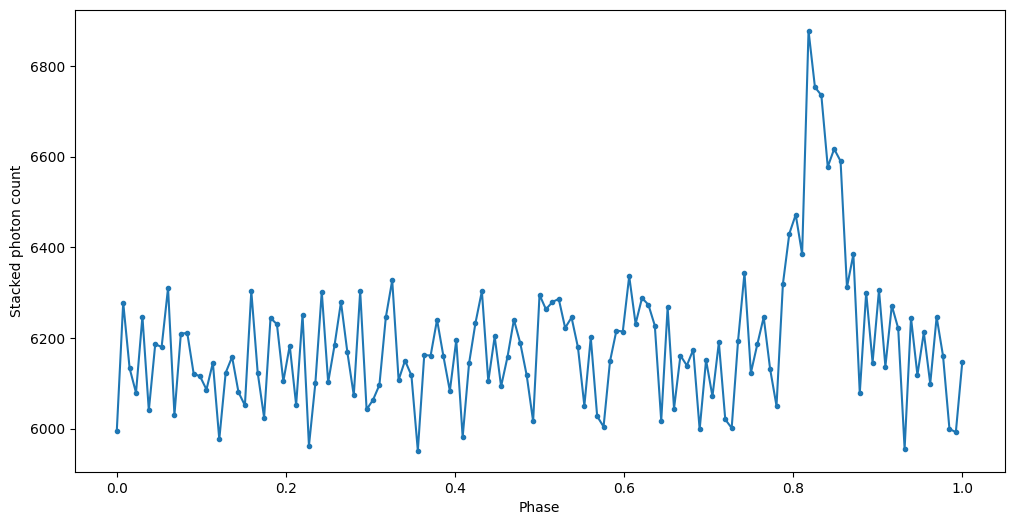

In [12]:
# plot the best folded profile

prof = folded_profiles['P0_133 DM_340']

fig, ax = plt.subplots(figsize=(12, 6))
phase = np.linspace(0, 1, len(prof))
ax.plot(phase, prof, 'C0.-')
ax.set_xlabel('Phase')
ax.set_ylabel('Stacked photon count')

We can visualise the SNR better if we make a 2D image of DM versus period, and set the colour equal to SNR.

The higher the SNR, the brighter the colour.

In [13]:
snr_matrix = np.array(snr_list).reshape((len(search_DMs), len(search_periods)))

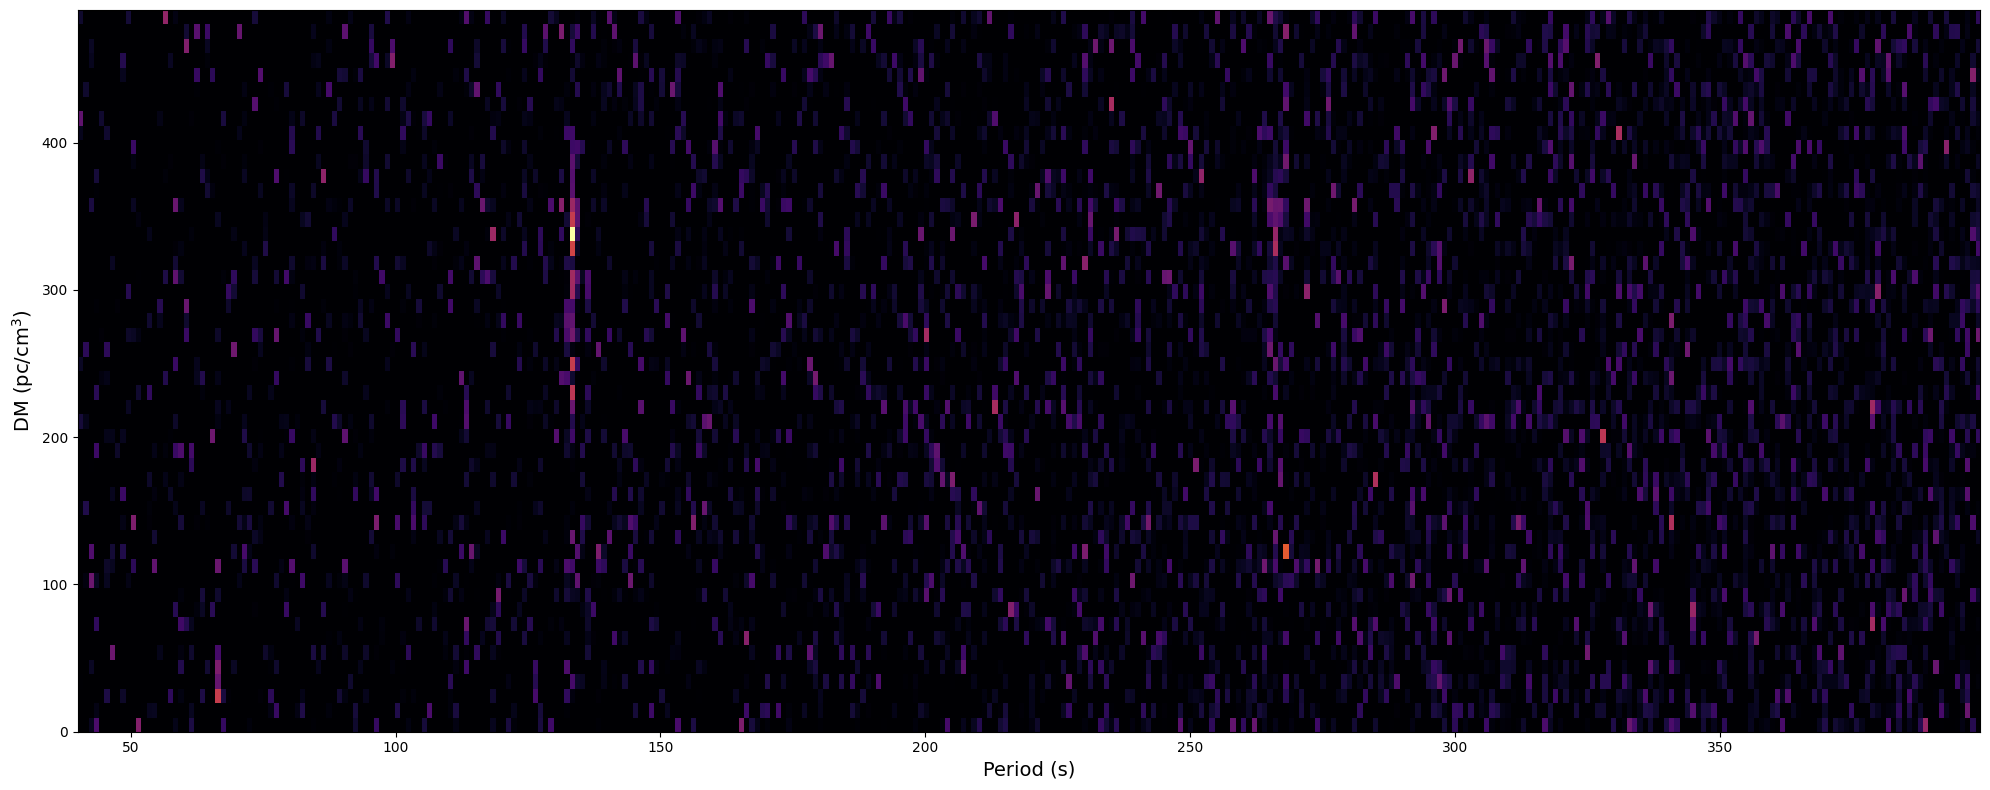

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.imshow(snr_matrix, aspect='auto', vmin=3, origin='lower', extent=[search_periods[0], search_periods[-1], search_DMs[0], search_DMs[-1]], cmap='inferno')
ax.set_ylabel('DM (pc/cm$^3$)', fontsize=14)
ax.set_xlabel('Period (s)', fontsize=14)
plt.tight_layout()